In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/Colab Notebooks/Project"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/A3/path/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import datetime
import os

## Data Visualization

In [ ]:
df = pd.read_csv("./driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [ ]:
num_dataset = len(df)
print("The number of Images in the dataset :", num_dataset)

The number of Images in the dataset : 22424


In [ ]:
df["labels"] = df["classname"].map(lambda x : int(x[1]))

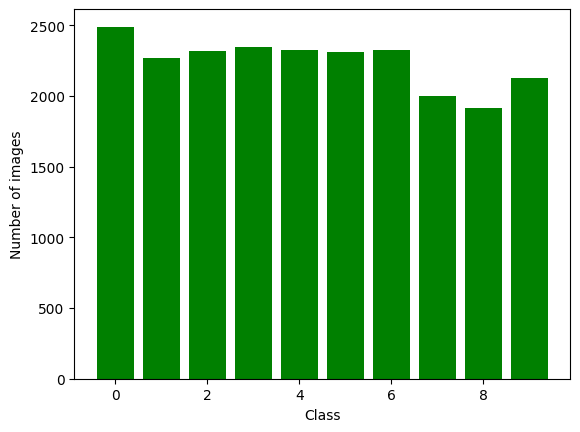

Number of Different Subject : 10
Average Number of Images per subject : 2242


In [ ]:
img_per_cls = df["labels"].value_counts()
plt.bar(img_per_cls.index, img_per_cls.values, color="green")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

print("Number of Different Subject :", len(img_per_cls.index))
print("Average Number of Images per subject :", img_per_cls.values.sum()//len(img_per_cls.index))

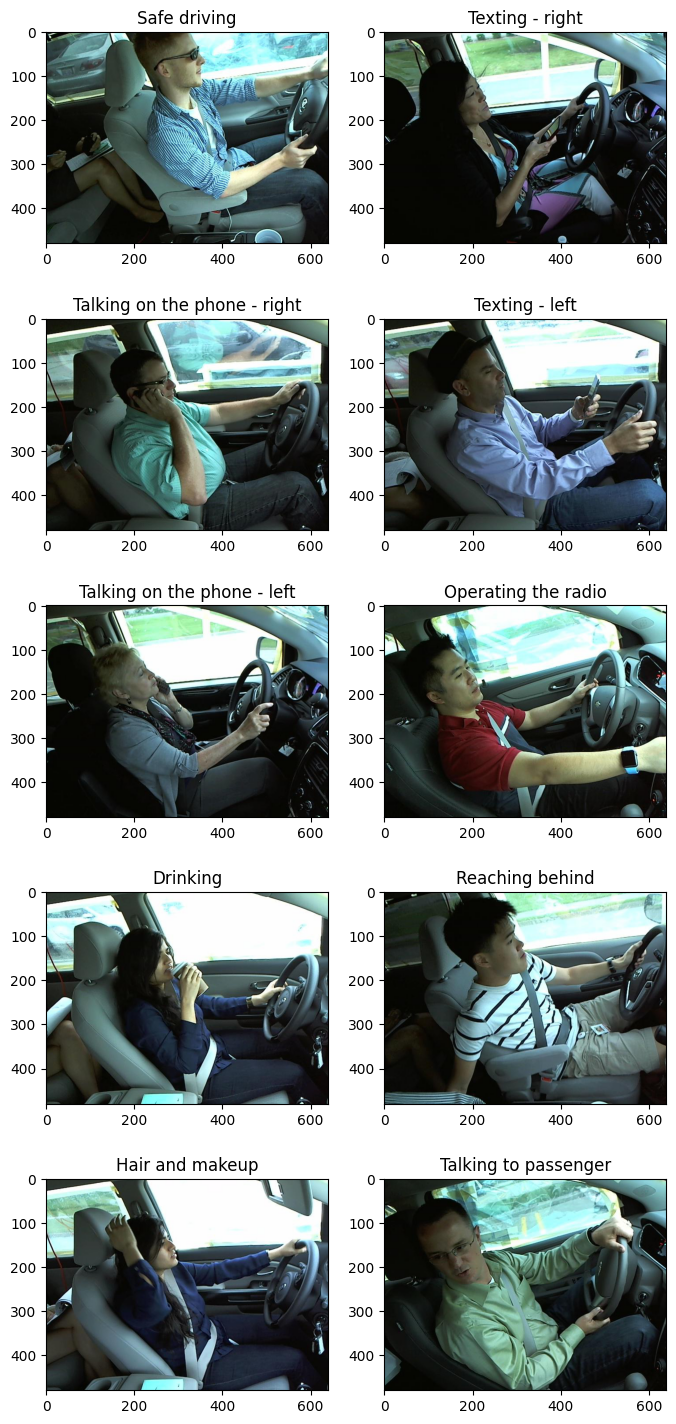

In [ ]:
class_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

plt.figure(figsize = (8, 18))
image_count = 1
BASE_URL = './imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(class_map[directory])

# Split data into training and validation

In [ ]:
import os
import random
import shutil
train_dir = './imgs/train'
val_dir = './imgs/val'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

subfolders = [f.path for f in os.scandir(train_dir) if f.is_dir()]

for subfolder in subfolders:
    if subfolder.endswith('val'):
        continue
    subfolder_name = os.path.basename(subfolder)
    val_subfolder_path = os.path.join(val_dir, subfolder_name)
    os.makedirs(val_subfolder_path, exist_ok=True)
    filenames = os.listdir(subfolder)
    random.shuffle(filenames)
    split_index = int(len(filenames) * 0.8)
    train_filenames = filenames[:split_index]
    val_filenames = filenames[split_index:]
    for filename in train_filenames:
        shutil.move(os.path.join(subfolder, filename), os.path.join(train_dir, subfolder_name, filename))
    for filename in val_filenames:
        shutil.move(os.path.join(subfolder, filename), os.path.join(val_subfolder_path, filename))

In [ ]:
from torchvision.datasets import ImageFolder
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root=root, transform=transform)

    def __getitem__(self, index):
        path, target = self.imgs[index]
        if not os.path.exists(path):
            raise FileNotFoundError(f"File {path} does not exist")
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [ ]:
batch_size = 128
img_width, img_height = 224, 224


train_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([transforms.Resize((img_width, img_height)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


In [ ]:
# # Create datasets for the training and validation sets
train_dataset = CustomImageFolder(train_dir, transform=train_transforms)
val_dataset = CustomImageFolder(val_dir, transform=val_transforms)

# Create data loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Evaluation

In [ ]:
import time

def run_test(model, testloader, criterion):
    
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
    
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)
    return val_loss, val_acc

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Train Densenet


In [ ]:
from torchvision.models import densenet121


In [ ]:
# replace the last fully connected layer of the model with a new one
densenet = densenet121(pretrained=True)

for param in densenet.parameters():
    param.requires_grad = False
# Create new Sequential module to append Softmax layer
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Sequential( 
                      nn.Linear(num_ftrs, 10),
                      nn.Softmax(dim=1))

# freeze the parameters of the pre-trained layers

for param in densenet.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.01)

In [ ]:
def train(model, criterion, optimizer, num_epochs, decay_epochs, init_lr, start_epoch=0):
    model = model.to(device)
    for epoch in range(start_epoch, num_epochs + start_epoch):
      train_loss = 0.0
      train_acc = 0.0
      val_loss = 0.0
      val_acc = 0.0
      
    
      # train the model on the training data
      model.train()
      
      for i, (inputs, labels) in enumerate(train_loader, 0):
          inputs, labels = inputs.to(device), labels.to(device)
          adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
          
      
      train_loss /= len(train_dataset)
      train_acc /= len(train_dataset)
      train_losses.append(train_loss)
      train_accs.append(train_acc)
  
      model.eval()
      val_loss, val_acc = run_test(model, val_loader, criterion)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      print(f'Epoch {epoch+1}/{num_epochs + start_epoch}: '
          f'Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')
    return train_accs,train_losses,val_accs, val_losses
      
   

100%|██████████| 253/253 [02:06<00:00,  2.00it/s]


Epoch 1/20: Training Loss: 2.1665, Training Acc: 0.3247, Validation Loss: 2.0785, Validation Acc: 0.4528


100%|██████████| 253/253 [02:06<00:00,  2.00it/s]


Epoch 2/20: Training Loss: 1.9595, Training Acc: 0.5909, Validation Loss: 1.9612, Validation Acc: 0.5584


100%|██████████| 253/253 [02:06<00:00,  2.01it/s]


Epoch 3/20: Training Loss: 1.8623, Training Acc: 0.6785, Validation Loss: 1.9097, Validation Acc: 0.6087


100%|██████████| 253/253 [02:05<00:00,  2.02it/s]


Epoch 4/20: Training Loss: 1.8145, Training Acc: 0.7145, Validation Loss: 1.8301, Validation Acc: 0.6959


100%|██████████| 253/253 [02:12<00:00,  1.91it/s]


Epoch 5/20: Training Loss: 1.7915, Training Acc: 0.7272, Validation Loss: 1.8210, Validation Acc: 0.7022


100%|██████████| 253/253 [02:08<00:00,  1.98it/s]


Epoch 6/20: Training Loss: 1.7719, Training Acc: 0.7419, Validation Loss: 1.7844, Validation Acc: 0.7417


100%|██████████| 253/253 [02:22<00:00,  1.78it/s]


Epoch 7/20: Training Loss: 1.7590, Training Acc: 0.7495, Validation Loss: 1.7815, Validation Acc: 0.7360


100%|██████████| 253/253 [02:20<00:00,  1.80it/s]


Epoch 8/20: Training Loss: 1.7481, Training Acc: 0.7564, Validation Loss: 1.7690, Validation Acc: 0.7454


100%|██████████| 253/253 [02:17<00:00,  1.84it/s]


Epoch 9/20: Training Loss: 1.7428, Training Acc: 0.7614, Validation Loss: 1.7722, Validation Acc: 0.7392


100%|██████████| 253/253 [02:20<00:00,  1.80it/s]


Epoch 10/20: Training Loss: 1.7321, Training Acc: 0.7683, Validation Loss: 1.7577, Validation Acc: 0.7548


100%|██████████| 253/253 [02:32<00:00,  1.66it/s]


Epoch 11/20: Training Loss: 1.7290, Training Acc: 0.7716, Validation Loss: 1.7595, Validation Acc: 0.7518


100%|██████████| 253/253 [02:17<00:00,  1.83it/s]


Epoch 12/20: Training Loss: 1.7228, Training Acc: 0.7722, Validation Loss: 1.7537, Validation Acc: 0.7511


100%|██████████| 253/253 [02:18<00:00,  1.83it/s]


Epoch 13/20: Training Loss: 1.7173, Training Acc: 0.7783, Validation Loss: 1.7393, Validation Acc: 0.7662


100%|██████████| 253/253 [02:21<00:00,  1.79it/s]


Epoch 14/20: Training Loss: 1.7138, Training Acc: 0.7813, Validation Loss: 1.7638, Validation Acc: 0.7336


100%|██████████| 253/253 [02:12<00:00,  1.91it/s]


Epoch 15/20: Training Loss: 1.7142, Training Acc: 0.7796, Validation Loss: 1.7240, Validation Acc: 0.7750


100%|██████████| 253/253 [02:10<00:00,  1.94it/s]


Epoch 16/20: Training Loss: 1.7032, Training Acc: 0.7905, Validation Loss: 1.7227, Validation Acc: 0.7811


100%|██████████| 253/253 [02:10<00:00,  1.94it/s]


Epoch 17/20: Training Loss: 1.7043, Training Acc: 0.7911, Validation Loss: 1.7216, Validation Acc: 0.7813


100%|██████████| 253/253 [02:06<00:00,  2.00it/s]


Epoch 18/20: Training Loss: 1.7005, Training Acc: 0.7931, Validation Loss: 1.7225, Validation Acc: 0.7803


100%|██████████| 253/253 [02:03<00:00,  2.05it/s]


Epoch 19/20: Training Loss: 1.7050, Training Acc: 0.7864, Validation Loss: 1.7214, Validation Acc: 0.7787


100%|██████████| 253/253 [02:03<00:00,  2.04it/s]


Epoch 20/20: Training Loss: 1.7026, Training Acc: 0.7899, Validation Loss: 1.7219, Validation Acc: 0.7813


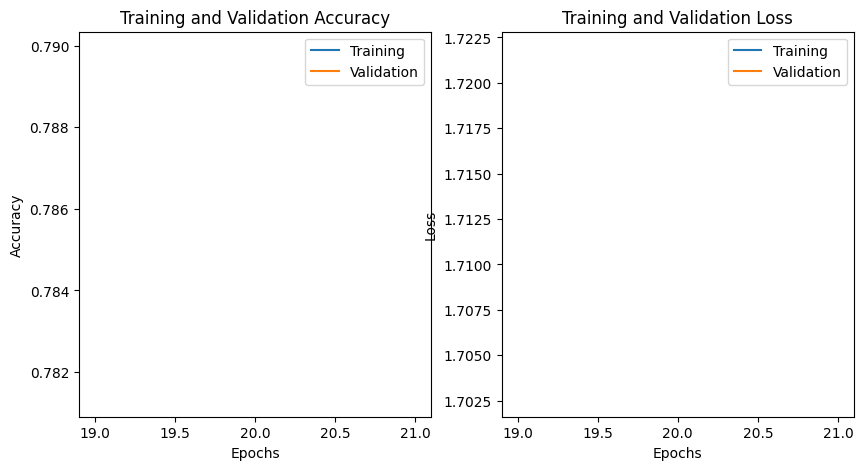

In [ ]:
train_losses = []
train_accs = []
val_accs = []
val_losses = []
train(densenet, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1)
model_path = 'densenet.pth'
torch.save(densenet.state_dict(), model_path)

Running for 11 Epochs


In [ ]:
# Load saved model
train(densenet, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1, start_epoch=6)
torch.save(densenet.state_dict(), model_path)

In [ ]:
# Load saved model
train(densenet, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1, start_epoch=11)
torch.save(densenet.state_dict(), model_path)

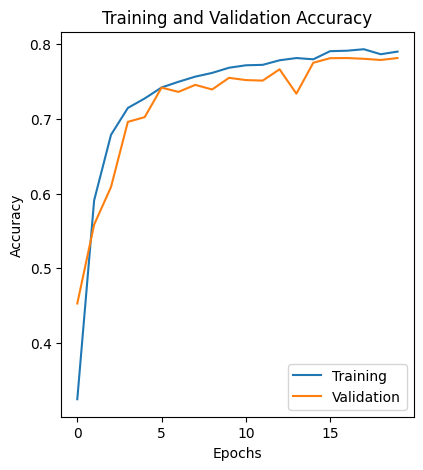

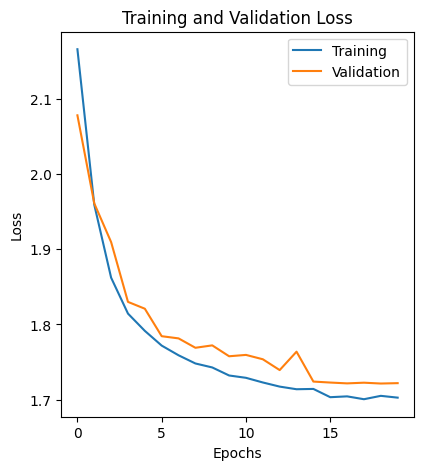

In [7]:
# Plotting Accuracy curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accs, label='Training')
plt.plot(range(num_epochs), val_accs, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Plotting Loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Training')
plt.plot(range(num_epochs), val_loss, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Train a Resnet 50

In [ ]:
from torchvision.models import resnet50

In [ ]:
resnet = resnet50(pretrained=True)

# Freeze all the parameters in the network
for param in resnet.parameters():
    param.requires_grad = False

# Add a new classifier layer with softmax activation function
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 10),
    nn.Softmax(dim=1)
)

# Enable training for the new classifier layer
for param in resnet.fc.parameters():
    param.requires_grad = True

In [ ]:
# set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.01)

In [ ]:
train_losses = []
train_accs = []
val_accs = []
val_losses = []
train(resnet, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1)
model_path = 'resnet.pth'
torch.save(resnet.state_dict(), model_path)

In [ ]:
# Load saved model
train(resnet, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1, start_epoch=6)
torch.save(resnet.state_dict(), model_path)

In [ ]:
# Load saved model
train(resnet, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1, start_epoch=11)
torch.save(resnet.state_dict(), model_path)

## SAVING THE MODEL

In [ ]:
model_path = "resnet50_classifier.pth"
torch.save(resnet.state_dict(), model_path)

In [ ]:
# Plotting Accuracy curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accs, label='Training')
plt.plot(range(num_epochs), val_accs, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Plotting Loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Training')
plt.plot(range(num_epochs), val_loss, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

##DISPLAY TEST DATA


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

plt.figure(figsize = (5,5))
image_count = 1
TEST_URL = './imgs/test/'
for filename in os.listdir(TEST_URL)[:5]:
    img = Image.open(os.path.join(TEST_URL, filename))
    plt.title("UNKNOWN")
    plt.imshow(img)
    plt.axis('off')
    image_count += 1
    plt.show()


## PREDICT

In [ ]:
import csv

TEST_URL = './imgs/test/'
fig = plt.figure(figsize=(10, 10))
with open('predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Filename', 'Predicted Class'])
    with torch.no_grad():
      for i, filename in enumerate(os.listdir(TEST_URL)[:5]):
          img = Image.open(os.path.join(TEST_URL, filename))
          img_tensor = test_transforms(img).unsqueeze_(0)
          output = densenet(img_tensor)
          _, pred = torch.max(output, 1)
          pred_class = class_map['c' + str(pred.item())]
          writer.writerow([filename, pred_class])
          ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
          ax.imshow(img)
          ax.set_title(f'Predicted: {pred_class}')
plt.show()